In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v3 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-11-11 15:02:20.625746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 15:02:20.625983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 15:02:20.660090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 15:02:20.660348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 15:02:20.660638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '004'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data = fl['all_data']
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

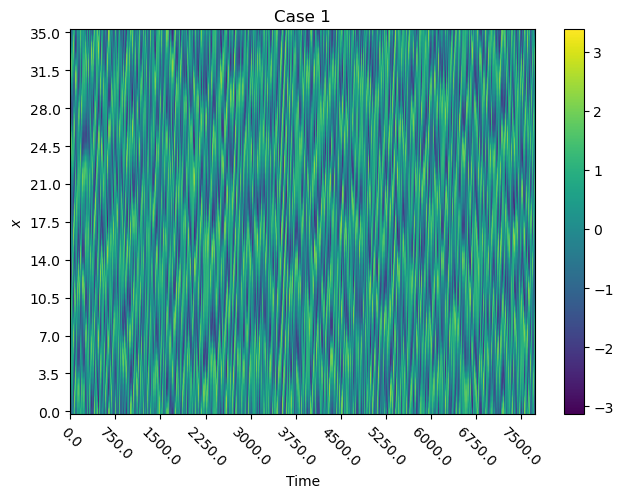

In [15]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = 25*np.round(10*float(sn[0:-6])/25)/10
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, numpoints_xgrid), dtype=np.float32)
        for i in range(numpoints_xgrid):
            sample_mean = np.mean(all_data[:, i])
            sample_std = np.std(all_data[:, i])
            all_data[:, i] -= sample_mean
            all_data[:, i] /= 3*sample_std
            normalization_constant_arr_aedata[0, i] = sample_mean
            normalization_constant_arr_aedata[1, i] = 3*sample_std

    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

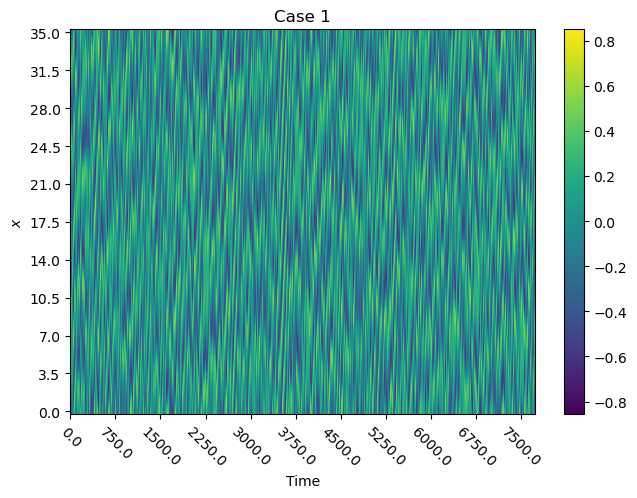

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

# Autoencoder

In [18]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 40  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-4  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [19]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [20]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [21]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    ae_net = Autoencoder(
        data_dim=all_data.shape[1],
        enc_layers=[128, 96, 64],
        dec_layers=[64, 96, 128],
        latent_space_dim=48,
        lambda_reg=lambda_reg,
        reg_name='L2',
        enc_layer_act_func='elu',
        enc_final_layer_act_func='tanh',
        dec_layer_act_func='elu',
        dec_final_layer_act_func='linear',
        load_file=None)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
    ae_net.load_weights_from_file(wt_file)

In [22]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [23]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
967/967 [==============================] - 5s 4ms/step - loss: 0.0348 - val_loss: 0.0168
Epoch 2/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 3/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 4/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 5/2000
966/967 [============================>.] - ETA: 0s - loss: 0.0153 - tot_time: 0h 0m 21.8s

Epoch 5: val_loss improved from inf to 0.01550, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoint

967/967 [==============================] - 4s 4ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 34/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 35/2000
959/967 [============================>.] - ETA: 0s - loss: 0.0140 - tot_time: 0h 2m 25.0s

Epoch 35: val_loss improved from 0.01425 to 0.01424, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 5s 5ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 36/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 37/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 38/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 39/2000
967/967 [============

Epoch 68/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 69/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 70/2000
948/967 [============================>.] - ETA: 0s - loss: 0.0140 - tot_time: 0h 4m 47.1s

Epoch 70: val_loss did not improve from 0.01417
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 71/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 72/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 73/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 74/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 75/2000
954/9

Epoch 104/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 105/2000
967/967 [==============================] - ETA: 0s - loss: 0.0140 - tot_time: 0h 7m 9.0s

Epoch 105: val_loss did not improve from 0.01415
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 106/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 107/2000
967/967 [==============================] - 5s 5ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 108/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 109/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 110/2000
961/967 [============================>.] - ETA: 0s - loss: 0.0140 - tot_time: 0h 7m 30.1s

Epoch 110:

965/967 [============================>.] - ETA: 0s - loss: 0.0140 - tot_time: 0h 9m 33.9s

Epoch 140: val_loss did not improve from 0.01415
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 141/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 142/2000
967/967 [==============================] - ETA: 0s - loss: 0.0140Restoring model weights from the end of the best epoch: 102.
 - tot_time: 0h 9m 42.0s
967/967 [==============================] - 4s 4ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 142: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
967

Epoch 31/2000
967/967 [==============================] - 4s 5ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 32/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 33/2000
959/967 [============================>.] - ETA: 0s - loss: 0.0139 - tot_time: 0h 11m 57.5s

Epoch 33: val_loss did not improve from 0.01402
967/967 [==============================] - 4s 4ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 34/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 35/2000
965/967 [============================>.] - ETA: 0s - loss: 0.0139 - tot_time: 0h 12m 5.9s
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 36/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 37/2000
967/967 [========

967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 67/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 68/2000
962/967 [============================>.] - ETA: 0s - loss: 0.0138 - tot_time: 0h 14m 22.6s

Epoch 68: val_loss did not improve from 0.01402
967/967 [==============================] - 4s 5ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 69/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 70/2000
957/967 [============================>.] - ETA: 0s - loss: 0.0138 - tot_time: 0h 14m 31.1s
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 71/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 72/2000
956/967 [=====================

Epoch 28/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 29/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 30/2000
960/967 [============================>.] - ETA: 0s - loss: 0.0138 - tot_time: 0h 16m 41.1s
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 31/2000
959/967 [============================>.] - ETA: 0s - loss: 0.0138 - tot_time: 0h 16m 45.1s

Epoch 31: val_loss did not improve from 0.01401
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 32/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 33/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 34/2000
967/967 [=======

Epoch 64/2000
967/967 [==============================] - 4s 5ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 65/2000
961/967 [============================>.] - ETA: 0s - loss: 0.0138 - tot_time: 0h 19m 5.9s
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_021/checkpoints/LossHistoriesCheckpoint
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 66/2000
952/967 [============================>.] - ETA: 0s - loss: 0.0138 - tot_time: 0h 19m 10.0s

Epoch 66: val_loss did not improve from 0.01401
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 67/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 68/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 69/2000
967/967 [==============================] - 4s 4ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 70/2000
962/967 [========

In [24]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = ae_net.evaluate(
        testing_data, testing_data,
    )

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

242/242 [==============================] - 1s 2ms/step - loss: 0.0139


In [25]:
lr_change

[0, 142, 214, 304]

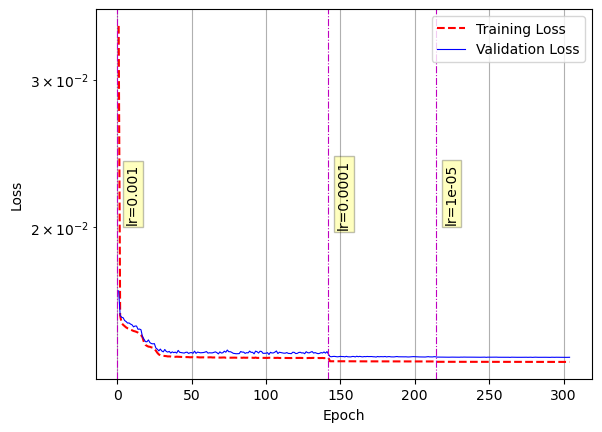

In [26]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [27]:
reconstructed_data = ae_net.predict(all_data)

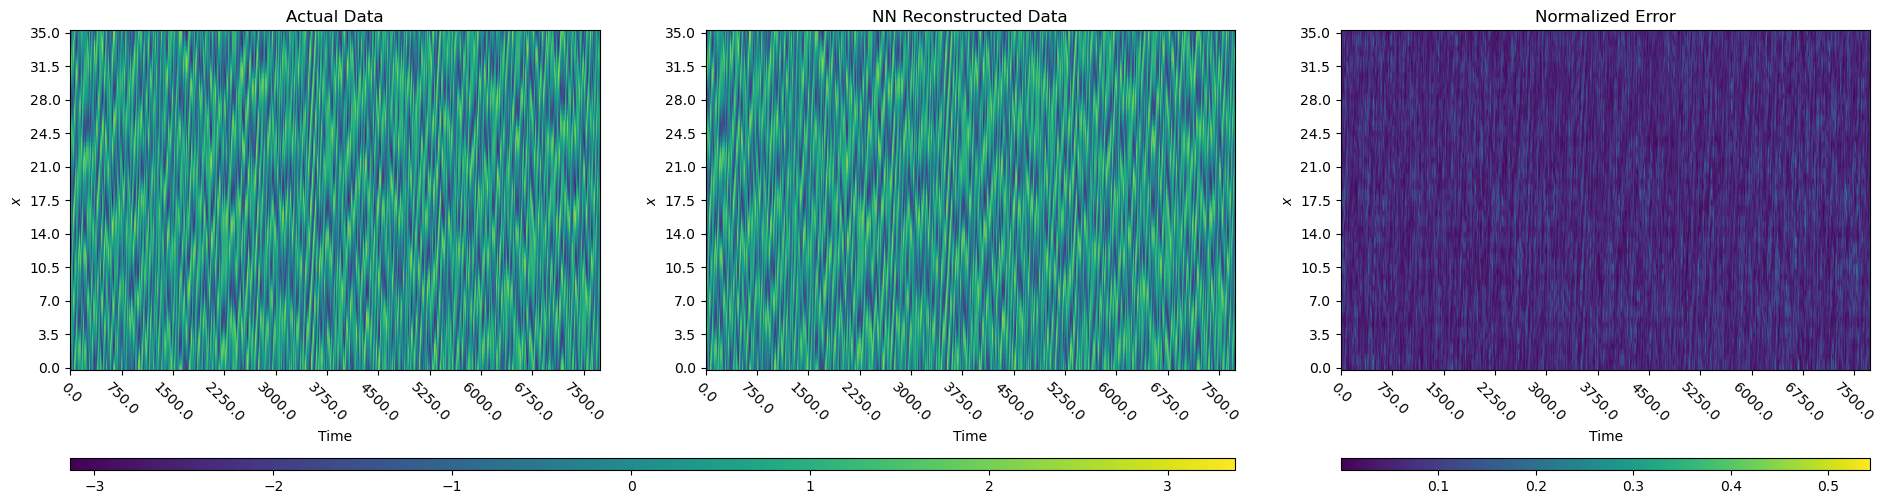

In [28]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [29]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [30]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

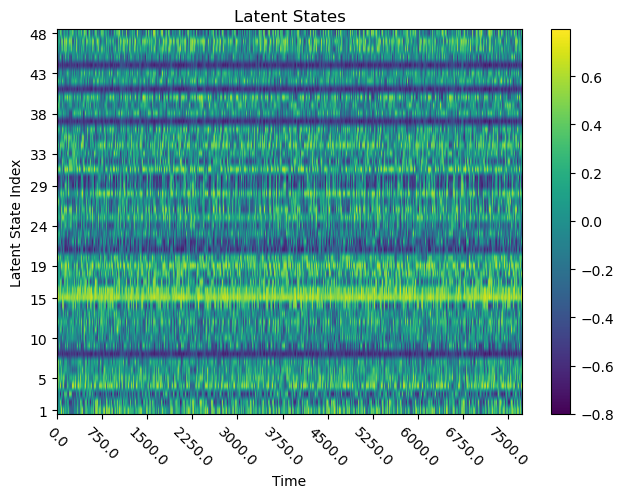

In [31]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=False)

In [32]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [33]:
# ae_net.summary()

In [34]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]].copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]].copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)
    
    begin_idx = boundary_idx_arr[i]

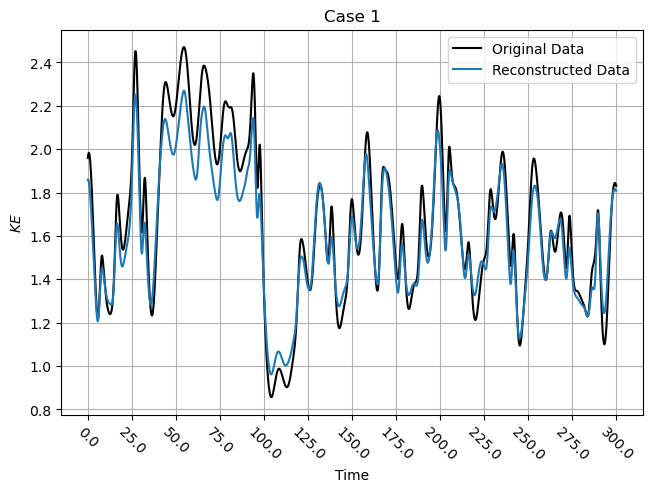

In [39]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)
start_time = 0
plot_time = 300

# '''
num_cols = 1
num_rows = 1
factor = 1
# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
#     next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
#     print(N)
    input_time = start_time + np.arange(0, N)*delta_t
    
    temp = N*delta_t
    chosen_interval = temp//10
    sn = np.format_float_scientific(chosen_interval, exp_digits=4)
#     print(temp, sn)
    snap = 25*np.round(10*float(sn[0:-6])/25)/10
    if snap == 0:
        snap = 0.1
    snap *= float('1'+sn[-6:])
    xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
#     print(xticks)
    ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

#     yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
#     yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
#     ax.set_yticks(ticks=yticks)
#     ax.set_yticklabels(yticklabels)

    ax.set_xlabel('Time')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
#     if ax_titles_list is not None:
#         ax.title.set_text(ax_titles_list[i])
#     else:
    ax.title.set_text(r'Case '+str(i+1))

#     plt.colorbar(im)
#     if save_dir is not None:
#         fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
#         fig.clear()
#         plt.close()
#     else:
    plt.show()
    print('')

    prev_idx = next_idx

In [50]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [51]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    begin_idx = boundary_idx_arr[i]

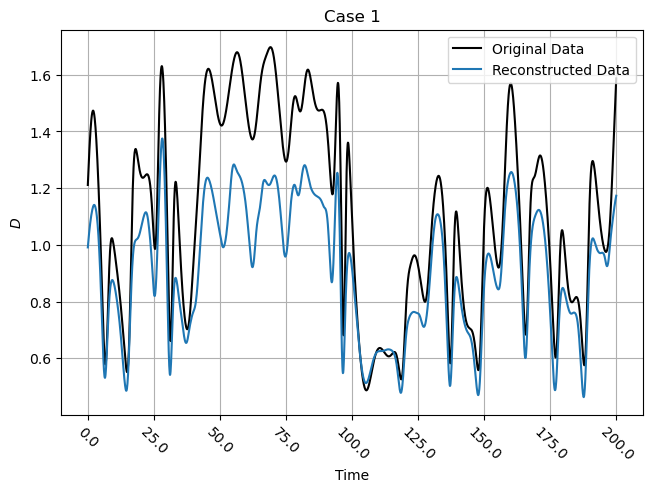

In [55]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)
start_time = 0
plot_time = 200

# '''
num_cols = 1
num_rows = 1
factor = 1
# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
#     next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
#     print(N)
    input_time = start_time + np.arange(0, N)*delta_t
    
    temp = N*delta_t
    chosen_interval = temp//10
    sn = np.format_float_scientific(chosen_interval, exp_digits=4)
#     print(temp, sn)
    snap = 25*np.round(10*float(sn[0:-6])/25)/10
    if snap == 0:
        snap = 0.1
    snap *= float('1'+sn[-6:])
    xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
#     print(xticks)
    ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

#     yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
#     yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
#     ax.set_yticks(ticks=yticks)
#     ax.set_yticklabels(yticklabels)

    ax.set_xlabel('Time')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
#     if ax_titles_list is not None:
#         ax.title.set_text(ax_titles_list[i])
#     else:
    ax.title.set_text(r'Case '+str(i+1))

#     plt.colorbar(im)
#     if save_dir is not None:
#         fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
#         fig.clear()
#         plt.close()
#     else:
    plt.show()
    print('')

    prev_idx = next_idx